In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import math
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib.patches import Rectangle, PathPatch
from tensorflow import keras as K
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import random
import ipdb

# sys.path.append('../../SketchRNN_tf2')
from sketchrnn_ouatai import models, dataset, utils

sns.set('notebook', 'whitegrid', rc=utils.mpl_rc())

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))

2021-09-07 17:13:40.804641: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-09-07 17:13:40.804765: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tf: 2.3.4
tf.keras: 2.4.0


In [2]:
import random
from PIL import Image
import io
import pandas as pd

In [3]:
!pwd
!ls ../../raw_data/models/

/home/tchook/code/Tchook115/ouatai/notebooks
models_sketch_rnn_airplane_weights.100.hdf5
models_sketch_rnn_angel_weights.100.hdf5


## dessine moi un objet

In [4]:
best_images = {
    #'bulldozer': np.load('/home/romain/code/Tchook115/raw_data/best_bulldozer_100_epochs.npy', allow_pickle=True),
    #'rabbit' : np.load('/home/romain/code/Tchook115/raw_data/best_rabbit.npy', allow_pickle=True), 
    #'cat' : np.load('/home/romain/code/Tchook115/raw_data/best_cat.npy', allow_pickle=True),
    #'ant' : np.load('/home/romain/code/Tchook115/raw_data/best_ant.npy', allow_pickle=True),
    #'basket' : np.load('/home/romain/code/Tchook115/raw_data/best_basket.npy', allow_pickle=True)
    'angel' : np.load('/home/tchook/code/Tchook115/raw_data/best_angel.npy', allow_pickle=True),
    'airplane' : np.load('/home/tchook/code/Tchook115/raw_data/best_airplane.npy', allow_pickle=True)
}
fichiers = {
#         'bulldozer': 'models_sketch_rnn_bulldozer_weights.100.hdf5', 
#         'cat' : 'sketch_rnn_cat_weights.78_0.01.hdf5',
#         'rabbit' : 'sketch_rnn_rabbit_weights.100_0.06.hdf5',
#         'ant' : ' models_sketch_rnn_ant_weights.100.hdf5',
#         'basket' : 'models_sketch_rnn_basket_weights.200.hdf5'
            'angel' : 'models_sketch_rnn_angel_weights.100.hdf5',
            'airplane' : 'models_sketch_rnn_airplane_weights.100.hdf5'
               }
words = ['angel', 'airplane']

In [ ]:
word = 'angel'
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for index, ax in enumerate(axs[0]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index]))
for index, ax in enumerate(axs[1]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index+10]))

In [5]:
def dessine_moi_un(word, temperature = 0.3, color = 'black', zoom = 1):
    
    if word not in words:
        return 'essaie un autre mot stp'
    
    #test de variables random
    max_seq_len = best_images[word][0].shape[0]-1
    data_train = [1 for k in range(10000)]
    
    hps = {
        "max_seq_len": max_seq_len,
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 1,
        "recurrent_dropout_prob": 0.1,
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }
    
    # load model
    sketchrnn = models.SketchRNN(hps)
    initial_epoch, initial_loss = 100, 0.06
    
    checkpoint = os.path.join('../../raw_data/models/', fichiers[word])
    sketchrnn.load_weights(checkpoint)
    
    # building image 
    best_pic = random.choice(best_images[word])
    d = np.expand_dims(best_pic,0)
    z = sketchrnn.models['encoder'].predict(d[:,1:])[0]
    strokes = sketchrnn.sample(z=z, temperature=temperature)
    
    final_object = utils.to_normal_strokes(strokes)
    figheight = 3*zoom
    figwidth = 3*zoom
    figsize = (figheight,figwidth)
    fig, ax = plt.subplots(figsize=figsize)
    utils.plot_strokes(ax, final_object, ec = color)
    
    # figure to PIL image
    buf = io.BytesIO()
    fig.savefig(buf, format='png',pad_inches=0,transparent=True)
    buf.seek(0)
    image = Image.open(buf)
    image = image.copy()
    buf.close()
    return image

In [ ]:
image = dessine_moi_un('angel')

In [ ]:
type(image)

In [ ]:
for k in range(5):
    dessine_moi_un('angel')

In [ ]:
ange = dessine_moi_un('angel', color = 'green', zoom = 1)

In [ ]:
type(ange)

In [ ]:
type(ange.size)

## la scene

In [6]:
scene_size = (2_000, 1_000)

In [7]:
def construis_la_scene(list_objects, scene_size = scene_size):
    '''
    list_objects = [[img_obj1, position_obj1], ...]
    '''
    scene = Image.new('RGBA', scene_size)
    for obj in list_objects:
        scene.paste(obj[0], obj[1])
        #scene = Image.alpha_composite(scene, obj[0])
    return scene

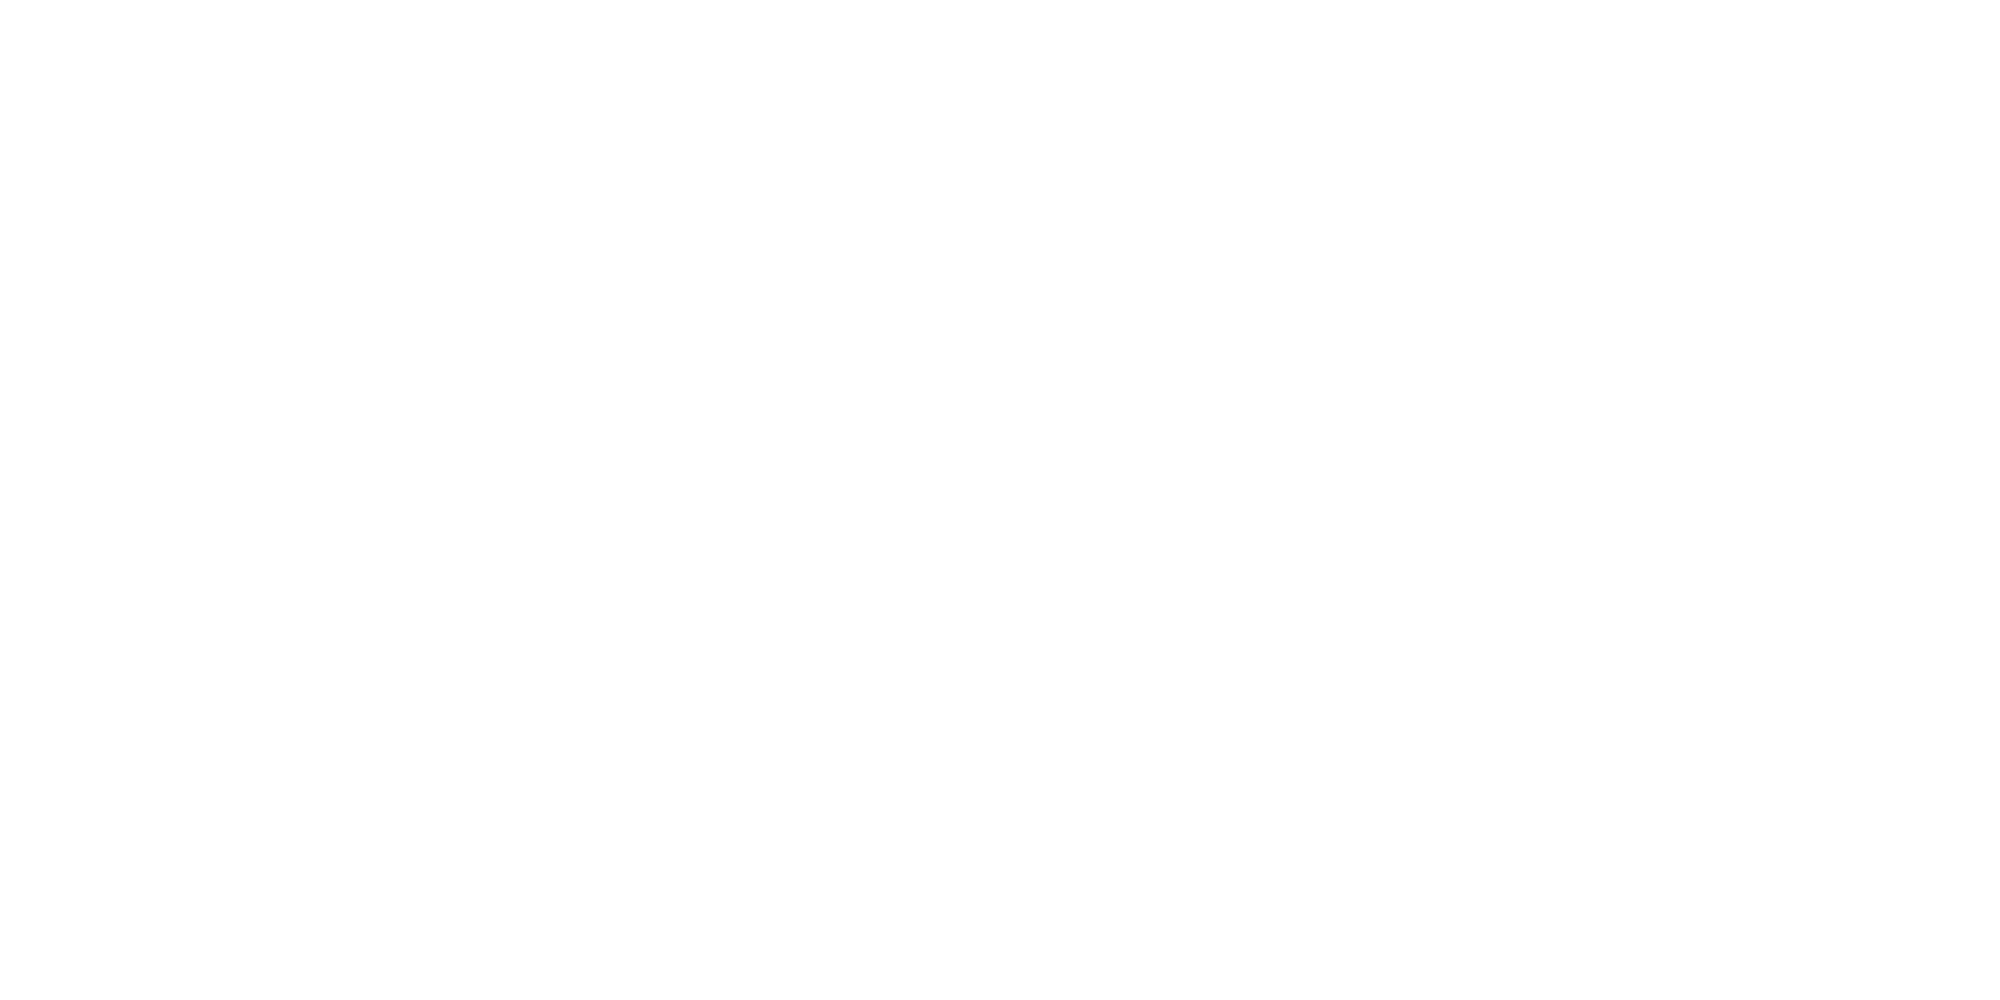

In [8]:
construis_la_scene([])

In [17]:
df = pd.DataFrame(np.array([['airplane', 'magenta', 'small', 3, 'centre', 'right'],
                            #['airplane', 'green', 'medium', 2, 'centre', 'right'],
                            ['airplane', 'blue', 'big', 1, 'centre', 'right'],
                            ]),
                   columns=['category', 'color', 'size', 'num', 'vertical_position', 'horizontal_position'])
df

,category,color,size,num,vertical_position,horizontal_position
0,airplane,magenta,small,3,centre,right
1,airplane,blue,big,1,centre,right


In [18]:
old_object = []
old_object
lst_coords = []

In [19]:
scene_size

(2000, 1000)

In [20]:
from PIL import ImageDraw

In [21]:
def check_position(hor_pos, vert_pos, imgwidth, imheight, old_object):
    x_min_new = hor_pos
    x_max_new = hor_pos + imgwidth
    y_min_new = vert_pos
    y_max_new = vert_pos + imheight
    if old_object:
        for elem in old_object:
            x_min = elem[0]
            x_max = x_min + elem[2]
            y_min = elem[1]
            y_max = y_min + elem[3]
            cond1 = x_min_new <= x_min and x_max_new > x_min 
            cond2 = x_min_new <= x_max and x_max_new > x_max
            cond3 = y_min_new <= y_min and y_max_new > y_min 
            cond4 = y_min_new <= y_max and y_max_new > y_max
            cond5 = x_min_new >= x_min and x_max_new < x_max
            cond6 = y_min_new >= y_min and y_max_new < y_max
            if (cond1 and (cond3 or cond4 or cond6)) or (cond2 and (cond3 or cond4 or cond6)) \
                or (cond5 and (cond3 or cond4 or cond6)):
                return False
    return True

In [22]:
def df_to_scene(df, scene_size = scene_size):
    list_objects = []
    list_position = []
    vertical_positions = {
        'top' : 0,
        'centre' : int(scene_size[1]/3),
        'bottom' : int(2*scene_size[1]/3)
    }
    horizontal_positions = {
        'left' : 0,
        'middle' : int(scene_size[0]/3),
        'right' : int(2*scene_size[0]/3)
    }
    sizes = {
        'small' : 1/2,
        'medium' : 1,
        'big' : 2
    }
    for index, row in df.iterrows():
        print(f'{index},{row}')
        for n in range(int(row['num'])):            
            category = row['category']
            color = row['color']
            size = sizes[row['size']]
            image = dessine_moi_un(category, color = color, zoom = size)
            imgwidth, imgheight = image.size
            #position
            starthoriz = horizontal_positions[row['horizontal_position']]
            stophoriz = starthoriz + (horizontal_positions['middle'] - imgwidth)
            startvert = vertical_positions[row['vertical_position']]
            stopvert = startvert + (vertical_positions['centre'] - imgheight)
            
            for _ in range(20):
                #check for collision
                hor = random.randint(starthoriz,stophoriz)
                vert = random.randint(startvert,stopvert)
                if check_position(hor, vert, imgwidth, imgheight, old_object):
                    #add image and its coordinates to list_objects
                    list_objects.append([image, (hor,vert)])
                    #lst_coords.append(hor,vert,imgwidth,imgheight)
                    #creating a new tuple in the old_object
                    print(old_object)
                    old_object.append((hor, vert, imgwidth, imgheight))
                    break
            
    scene = construis_la_scene(list_objects, scene_size)
    #Les traits noirs
    draw = ImageDraw.Draw(scene)
    for h in range(scene_size[0]):
        draw.point((h,vertical_positions['centre']), fill="black")
    for h in range(scene_size[0]):
        draw.point((h,vertical_positions['bottom']), fill="black")
    for v in range(scene_size[1]):
        draw.point((horizontal_positions['middle'], v), fill="black")
    for v in range(scene_size[1]):
        draw.point((horizontal_positions['right'], v), fill="black")
    return scene

0,category               airplane
color                   magenta
size                      small
num                           3
vertical_position        centre
horizontal_position       right
Name: 0, dtype: object
[]
[(1488, 450, 83, 81)]
[(1488, 450, 83, 81), (1381, 550, 83, 81)]
1,category               airplane
color                      blue
size                        big
num                           1
vertical_position        centre
horizontal_position       right
Name: 1, dtype: object
CPU times: user 14 s, sys: 795 ms, total: 14.8 s
Wall time: 12.2 s


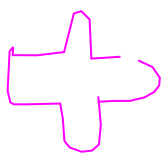

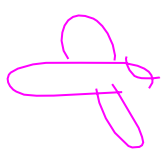

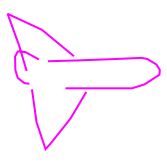

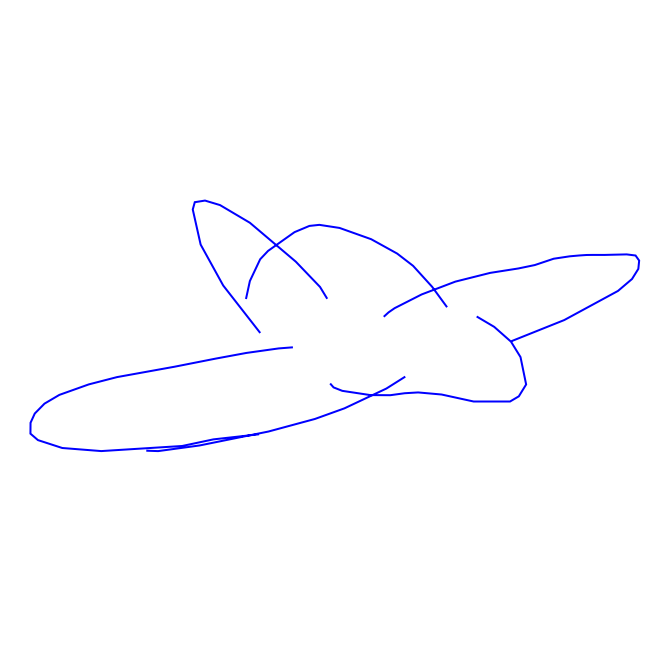

In [23]:
%%time
scene = df_to_scene(df)

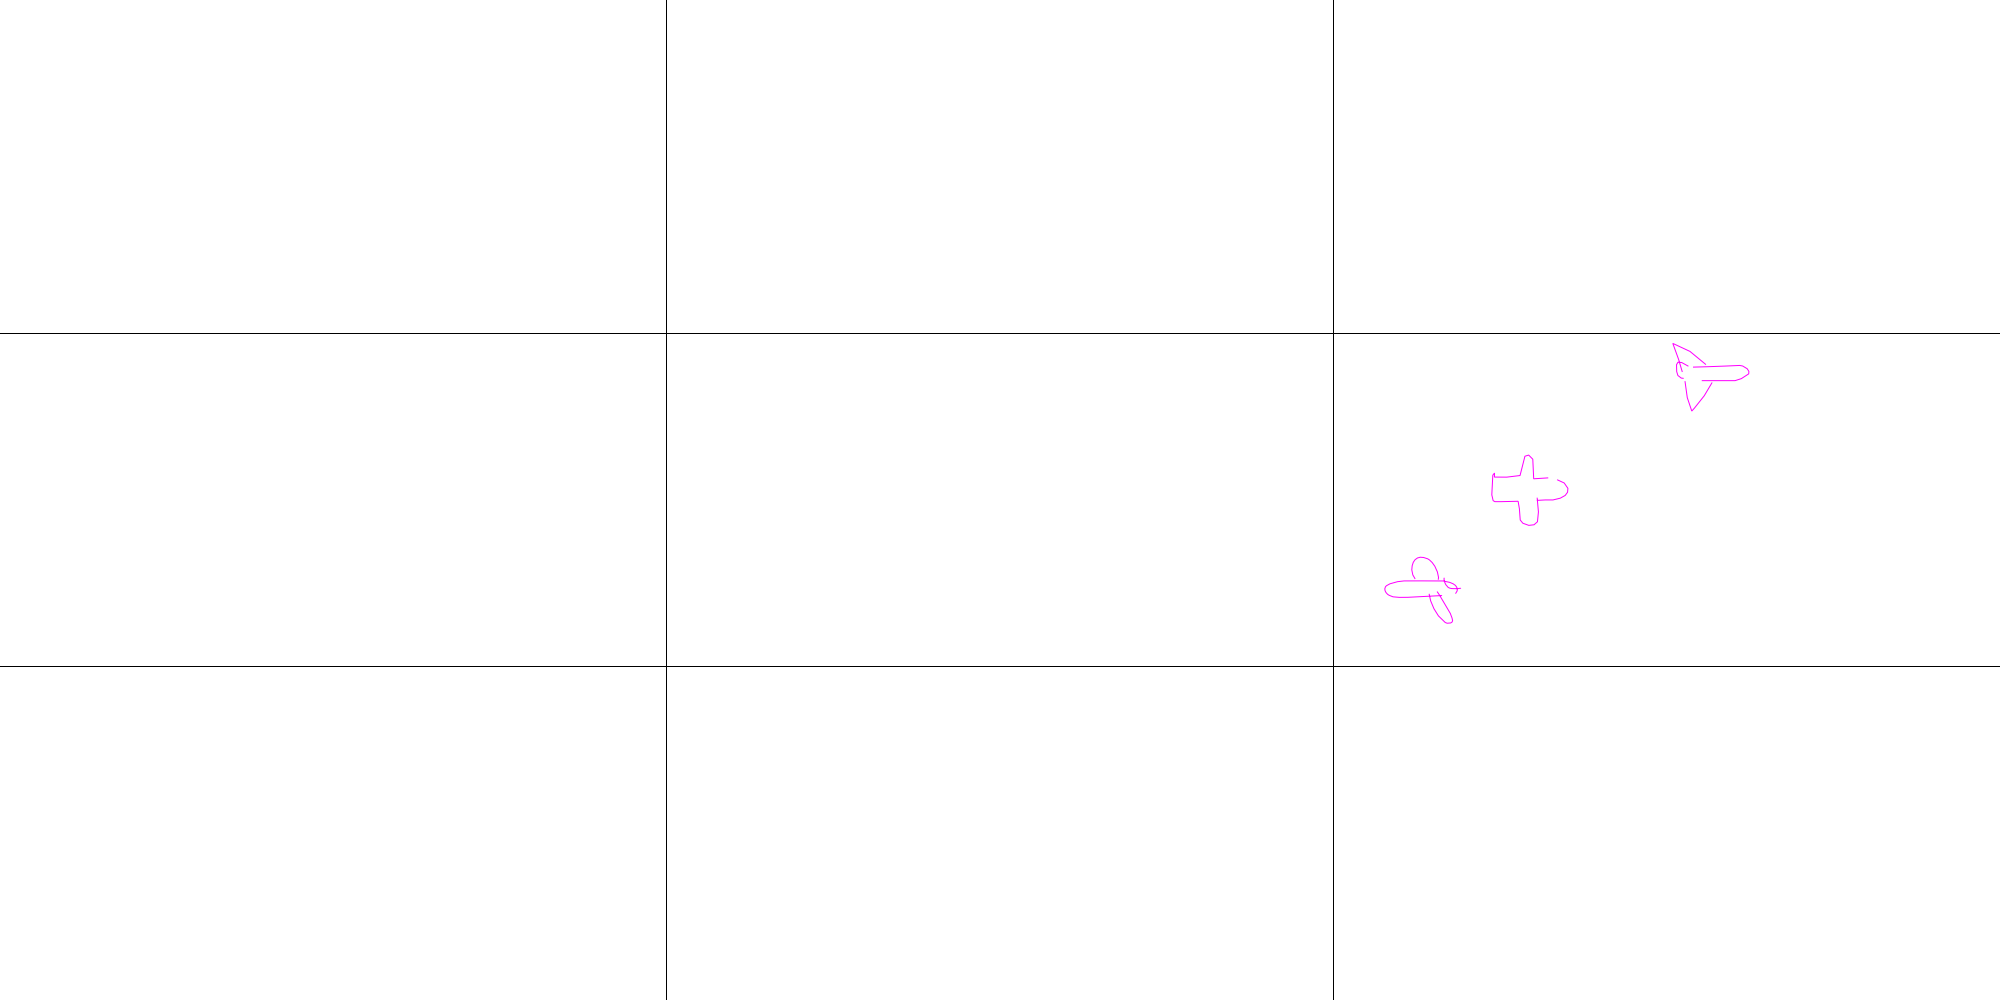

In [24]:
scene

In [ ]:
scene1 = df_to_scene(df)
scene2 = df_to_scene(df)

In [ ]:
scene1

In [ ]:
scene2

In [ ]:
final2 = Image.new("RGBA", scene1.size)
final2 = Image.alpha_composite(final2, scene1)
final2 = Image.alpha_composite(final2, scene2)